#### **Import load profiles and remove incomplete days**

In [1]:
import pandas as pd

loadProfiles_df = pd.read_parquet(r'data/load_profiles.parquet.gzip')

In [2]:
from preprocessing import remove_incomplete_days

loadProfiles_df = remove_incomplete_days(loadProfiles_df)

#### **Inspect the data**

In [3]:
display(loadProfiles_df.head())
for col in loadProfiles_df.columns:
    if not col.isnumeric():
        print(col) 

,timestamp,date,year,meteorological season,month,month of the year,week of the year,day of the month,weekday,hour of the day,...,1163,1175,1193,1229,1231,1234,1272,1286,1298,1309
23,2021-06-02 00:00:00,2021-06-02,2021,Summer,June,6,22,2,Wednesday,1,...,33.0,55.0,0.0,201.0,276.0,337.0,305.0,306.0,12.0,225.0
24,2021-06-02 01:00:00,2021-06-02,2021,Summer,June,6,22,2,Wednesday,2,...,32.0,57.0,0.0,91.0,74.0,689.0,156.0,251.0,12.0,272.0
25,2021-06-02 02:00:00,2021-06-02,2021,Summer,June,6,22,2,Wednesday,3,...,34.0,51.0,0.0,87.0,53.0,629.0,145.0,106.0,12.0,140.0
26,2021-06-02 03:00:00,2021-06-02,2021,Summer,June,6,22,2,Wednesday,4,...,33.0,62.0,0.0,87.0,54.0,352.0,149.0,93.0,13.0,99.0
27,2021-06-02 04:00:00,2021-06-02,2021,Summer,June,6,22,2,Wednesday,5,...,33.0,47.0,0.0,86.0,54.0,298.0,247.0,99.0,12.0,137.0


timestamp
date
year
meteorological season
month
month of the year
week of the year
day of the month
weekday
hour of the day
day off
weekend
holiday


#### **Select and visualize a profile**

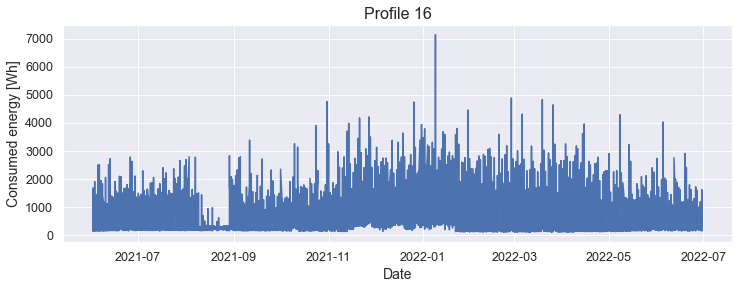

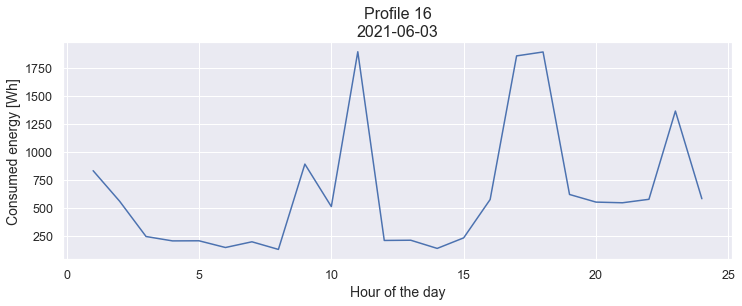

In [4]:
from plotting import plot_profile, plot_subsequence
import seaborn as sns
sns.set_theme()

# Select a profile
profile = '16'

# Plot the whole profile
plot_profile(loadProfiles_df, profile)

# Plot a selected day
plot_subsequence(loadProfiles_df, profile, '2021-06-03')

#### **Create and train a model**

**Set the parameters**

In [5]:
from gretel_synthetics.timeseries_dgan.config import DGANConfig
from gretel_synthetics.timeseries_dgan.dgan import DGAN

config = DGANConfig(
    max_sequence_len = 24,
    sample_len = 1,
    feature_noise_dim = 32,
    feature_num_layers = 1,
    feature_num_units = 100,
    apply_feature_scaling = True,
    apply_example_scaling = False,
    generator_learning_rate = 2*1e-5,
    discriminator_learning_rate = 2*1e-5,
    attribute_discriminator_learning_rate = 2*1e-5,
    batch_size = 100,
    epochs = 10,   #typically >=1e5
    attribute_loss_coef = 10
)

**Create the model**

In [6]:
model = DGAN(config)

**Create an example ID column**

Used by DoppelGANger to split long format data into multiple samples.

In [7]:
dateIndex_dict = {item: idx for idx, item in enumerate(loadProfiles_df['date'].unique())}
loadProfiles_df['date index'] = loadProfiles_df['date'].map(dateIndex_dict)

**Select a profile and train the model**

For each month profiles for holidays/weekends and profiles for working days are created.  
This is specified in the list `attributes`.

In [8]:
profile = '16'
attributes = ['month of the year', 'day off']

model.train_dataframe(
   loadProfiles_df,
   attribute_columns = attributes,
   feature_columns = [profile],
   example_id_column = 'date index',
   time_column = 'timestamp',
   discrete_columns = attributes,
   df_style = 'long'
)

2023-05-29 00:16:41,533 : MainThread : INFO : epoch: 0
2023-05-29 00:16:45,862 : MainThread : INFO : epoch: 1
2023-05-29 00:16:46,113 : MainThread : INFO : epoch: 2
2023-05-29 00:16:46,399 : MainThread : INFO : epoch: 3
2023-05-29 00:16:46,649 : MainThread : INFO : epoch: 4
2023-05-29 00:16:46,920 : MainThread : INFO : epoch: 5
2023-05-29 00:16:47,172 : MainThread : INFO : epoch: 6
2023-05-29 00:16:47,423 : MainThread : INFO : epoch: 7
2023-05-29 00:16:47,674 : MainThread : INFO : epoch: 8
2023-05-29 00:16:47,958 : MainThread : INFO : epoch: 9


**Save the trained model**

In [9]:
#model.save('models/model.DGAN')

#### **Create and visualize synthetic data**

**Import existing model**

In [10]:
model = DGAN.load('models/model.DGAN')

**Create synthetic data**

For the parameter `n` in the `generate_dataframe()` function we choose the number of days we want to create.

In [11]:
syntheticProfiles_df = model.generate_dataframe(n = 500)

syntheticProfiles_df.head()

,timestamp,month of the year,day off,16,date index
0,2021-06-02 00:00:00,12,0,1038.009766,0
1,2021-06-02 01:00:00,12,0,2140.489014,0
2,2021-06-02 02:00:00,12,0,235.379471,0
3,2021-06-02 03:00:00,12,0,537.772461,0
4,2021-06-02 04:00:00,12,0,431.778992,0


**Analyze results**

Missing: month: 4 | day off: 0


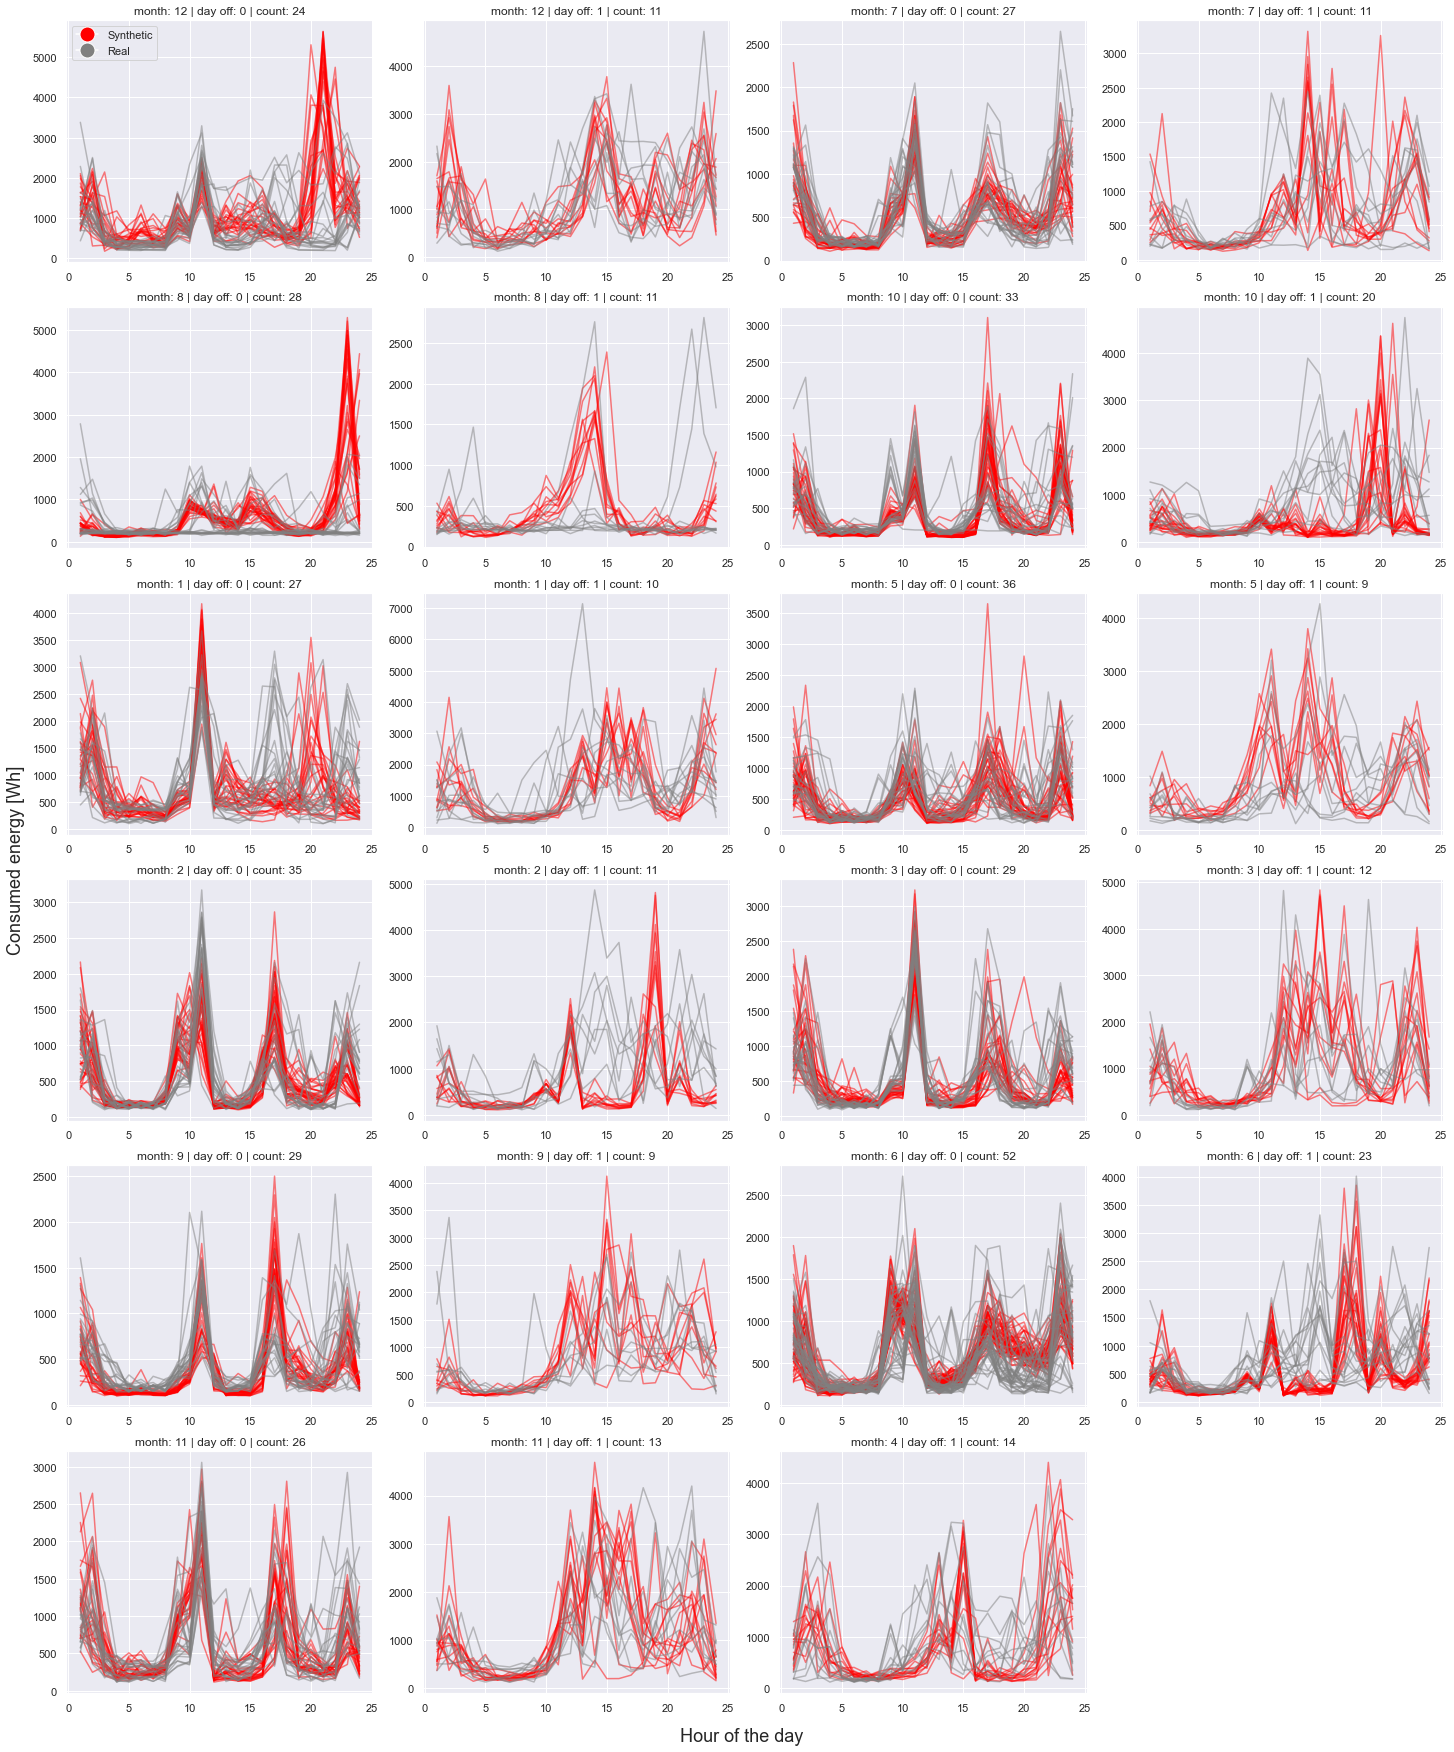

In [12]:
from plotting import visualize_and_analyse_synthetic_profiles

visualize_and_analyse_synthetic_profiles(syntheticProfiles_df, loadProfiles_df, profile = profile, attributes = attributes)

##### Main problems with DoppelGANger

* Conditional data generation is not supported. In our example, combinations of `month` and `day off` (either True or False) are generated at random. As seen above, some combinations might only be generated very rarely or not at all.

* Multiple examples are needed to train the GAN. In the example above we synthetized characteristic days. It is not recommended to concatenate those days to create load profiles for the whole date range due to discontinuities.